In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


# load MATLAB files
from scipy.io import loadmat
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
import sys
from sklearn.linear_model import LogisticRegression
 
#%config InlineBackend.figure_formats = {'pdf',}
#%matplotlib inline

import seaborn as sns

plt.close("all") # Clsoe all plots


### Loading data 

X: (5000, 401) (with intercept)
y: (5000, 1)

Number of features (n): 401
Number of training examples (nm): 5000

theta1: (25, 401)
theta2: (10, 26)

Sample:


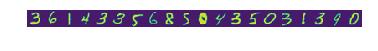

In [32]:
# Load data
data = loadmat('data/ex3data1.mat')
data.keys()


#Load th weights
weights = loadmat('ex3weights.mat')
weights.keys()

y = data['y']

# Add x0 
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]

m,n = X.shape
 
print('X: {} (with intercept)'.format(X.shape))
print('y: {}'.format(y.shape))

print('\nNumber of features (n): %.0f'%(n))
print('Number of training examples (nm): %.0f'%(m))

theta1, theta2 = weights['Theta1'], weights['Theta2']

print('\ntheta1: {}'.format(theta1.shape))
print('theta2: {}'.format(theta2.shape))

sample = np.random.choice(X.shape[0], 20)
print('\nSample:')
plt.imshow(X[sample,1:].reshape(-1,20).T)
plt.axis('off');

## Multiclass Logistic Regression

Note: \theta_0 is not to be regularised adn is calcualted seperately when using the vertorised method

Hypothesis:
Sigmoid Function $$h_\theta(x) = g(\theta^{T}x)$$

$$h_\theta(x) = g(\theta x) = \frac{1}{1 + e^{-\theta^{T}x}}$$

Regularized Cost Function
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)} log( h_\theta(x^{(i)}))+(1-y^{(i)})log(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$


Vectorized Cost Function
$$ J(\theta) = -\frac{1}{m}\big((log(h)^Ty+(log(1-h)^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j = 1}^{n}\theta_{j}^{2}$$

Partial derivative:
$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} \frac{\lambda}{m}\theta_{j}^{2}$$

Vectorized Partial Derivative
$$\frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h-y) + \frac{\lambda}{m}\theta_{j}^{2}$$

Gradient Descent: Repeat until converge
$$\theta_0 : = \theta_0- \alpha\frac{1}{m}\frac{\delta J(\theta)}{\delta\theta_{0}}$$

$$\theta_j : = \theta_j- \alpha\Big[\Big(\frac{1}{m}\frac{\delta J(\theta)}{\delta\theta_{j}}\Big) + \frac{\lambda}{m}\theta_{j}\Big] j\epsilon{1,2,3...n}$$
                                

### Regularised Cost Function

In [33]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))
    
#logitic regression cost fucntion (Regularised)
def lrcostFunctionReg(theta, reg, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    #cost fuinction
    J = -1 * (1/m) * (np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y)) + (reg/(2 * m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])    

# logistic regreession gradient of cost function
def lrgradientReg(theta, reg, X,y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
     
    #Gradient
    grad = (1/m)*X.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

### One - Vrs - All Prediction

In [34]:

# logistic regression - one - Vrs - all
def oneVsAll(features, classes, n_labels, reg):
    initial_theta = np.zeros((X.shape[1],1))  # 401x1
    all_theta = np.zeros((n_labels, X.shape[1])) #10x401

    for c in np.arange(1, n_labels+1):
        res = minimize(lrcostFunctionReg, initial_theta, args = (reg, features, (classes == c) * 1), 
                       method = None,jac = lrgradientReg, options = {'maxiter':50})
        all_theta[c-1] = res.x
    return(all_theta)

theta = oneVsAll(X, y, 10, 0.1)

def predictOneVsAll(all_theta, features):
    probs = sigmoid(X.dot(all_theta.T))
        
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis = 1) + 1)
 
pred = predictOneVsAll(theta, X)
print('Training set accuracy with 1-V-all: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy with 1-V-all: 93.24 %


### Multiclass Logistic Regression with scikit-learn

In [35]:
clf = LogisticRegression(C = 10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:,1:],y.ravel())

pred2 = clf.predict(X[:,1:])
print('Training set accuracy with sklearn: {} %'.format(np.mean(pred2 == y.ravel())*100))


Training set accuracy with sklearn: 96.5 %


### Neural Networks

In [36]:
def predict(theta_1, theta_2, features):
    z2 = theta_1.dot(features.T)
    a2 = np.c_[np.ones((data['X'].shape[0],1)), sigmoid(z2).T]
    
    z3 = a2.dot(theta_2.T)
    a3 = sigmoid(z3)
        
    return(np.argmax(a3, axis=1)+1) 

pred = predict(theta1, theta2, X)
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 97.52 %
